In [1]:
################################################################################################################################
#
# LSTM - JANSEN - FRACDIFF - LN
#
################################################################################################################################

#-------------------------------------------------------------------------------------------------------------------------------
# 
#-------------------------------------------------------------------------------------------------------------------------------

#===============================================================================================================================
# ENVIRONMENT: LIBRARIES, SETTINGS
#===============================================================================================================================
#pip install pandas-datareader

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import pandas_datareader.data as web
import sklearn
import sklearn.preprocessing
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation
from tensorflow import keras

In [2]:
#===============================================================================================================================
# ENVIRONMENT: HARDWARE
#===============================================================================================================================
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [3]:
#===============================================================================================================================
# ENVIRONMENT: CONFIG
#===============================================================================================================================
sns.set_style('whitegrid')
np.random.seed(42)

In [4]:
#===============================================================================================================================
# DATA: INPUT/OUTPUT
#===============================================================================================================================
input_path = Path('Data', 'Input')
results_path = Path('Data\Output', 'Jansen-LSTM-FracDiff-Ln')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [5]:
#===============================================================================================================================
# DATA: SETTINGS
#===============================================================================================================================
seriesId='IBOV-FracDiff-Ln'
#ESCALA = 'log'
#EPOCAS = 100
#LOTE = 50
#NEURONS = 32
window_size=21

In [6]:
#===============================================================================================================================
# DATA: READ - FFD
#===============================================================================================================================
df = pd.read_csv('Data/Input/'+seriesId+'.csv')
#df['Date']= pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)
df

,Close
Date,
2001-09-20,1.407736
2001-09-21,1.402014
2001-09-24,1.419516
2001-09-25,1.391312
2001-09-26,1.379019
...,...
2023-12-21,1.945807
2023-12-22,1.946708
2023-12-26,1.949707


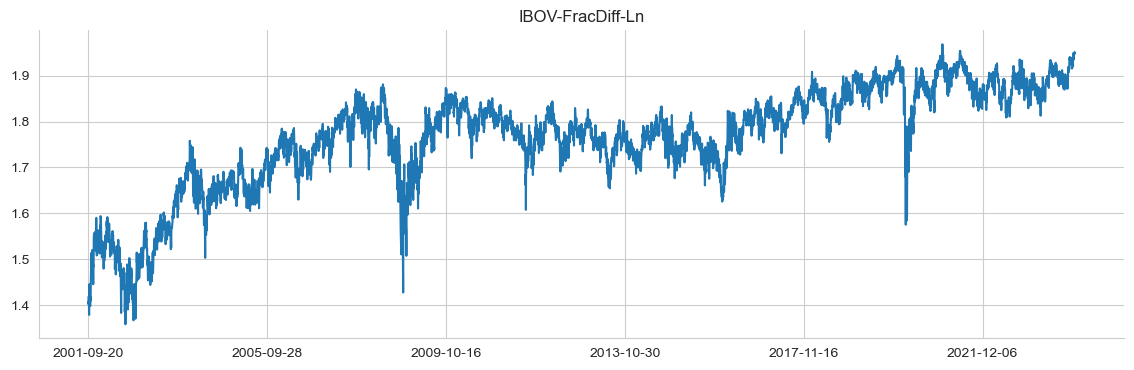

In [7]:
#===============================================================================================================================
# DATA: PLOT
#===============================================================================================================================
ax = df.plot(title=seriesId, legend=False, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [8]:
#===============================================================================================================================
# DATA: SCALE - NO SCALE (ALREADY IN LN, JUST COPY)
#===============================================================================================================================
df_scaled = df.copy()
#df_scaled['Close'] = np.log(df_scaled['Close'])

#print(df_scaled.describe())
df_scaled

,Close
Date,
2001-09-20,1.407736
2001-09-21,1.402014
2001-09-24,1.419516
2001-09-25,1.391312
2001-09-26,1.379019
...,...
2023-12-21,1.945807
2023-12-22,1.946708
2023-12-26,1.949707


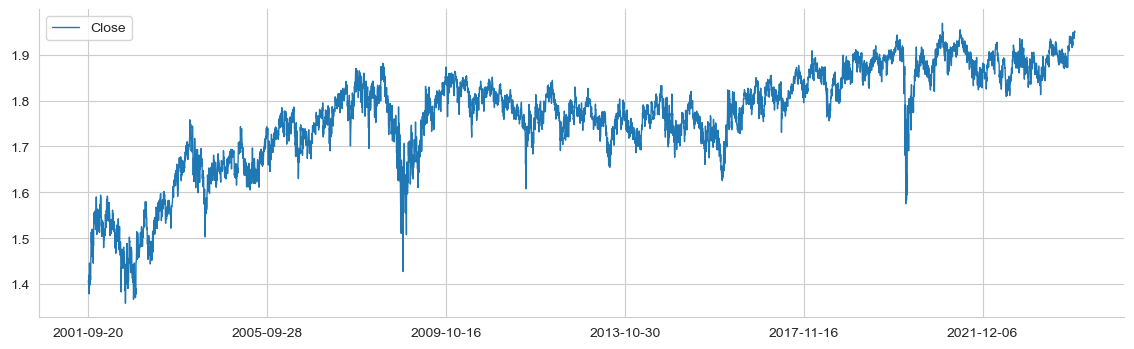

In [9]:
#===============================================================================================================================
# DATA: PLOT
#===============================================================================================================================
ax = df_scaled.plot(lw=1, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [10]:
#===============================================================================================================================
# DATA PREP: RECURRENT SEQUENCES - FUNCTION
#===============================================================================================================================
def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    #y = data[window_size-1:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    #X = np.hstack(tuple([data[i: n-j+1, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

In [11]:
#===============================================================================================================================
# DATA PREP: RECURRENT SEQUENCES - RUN
#===============================================================================================================================
X, y = create_univariate_rnn_data(df_scaled, window_size=window_size)
X


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
Date,,,,,,,,,,,,,,,,,,,,,
2001-10-22,1.407736,1.402014,1.419516,1.391312,1.379019,1.428793,1.446096,1.427873,1.415822,1.409546,...,1.419255,1.409627,1.432566,1.447395,1.473513,1.513858,1.491502,1.488186,1.460166,1.494912
2001-10-23,1.402014,1.419516,1.391312,1.379019,1.428793,1.446096,1.427873,1.415822,1.409546,1.398322,...,1.409627,1.432566,1.447395,1.473513,1.513858,1.491502,1.488186,1.460166,1.494912,1.520015
2001-10-24,1.419516,1.391312,1.379019,1.428793,1.446096,1.427873,1.415822,1.409546,1.398322,1.419255,...,1.432566,1.447395,1.473513,1.513858,1.491502,1.488186,1.460166,1.494912,1.520015,1.501669
2001-10-25,1.391312,1.379019,1.428793,1.446096,1.427873,1.415822,1.409546,1.398322,1.419255,1.409627,...,1.447395,1.473513,1.513858,1.491502,1.488186,1.460166,1.494912,1.520015,1.501669,1.486509
2001-10-26,1.379019,1.428793,1.446096,1.427873,1.415822,1.409546,1.398322,1.419255,1.409627,1.432566,...,1.473513,1.513858,1.491502,1.488186,1.460166,1.494912,1.520015,1.501669,1.486509,1.509955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21,1.933918,1.935650,1.924409,1.926552,1.931923,1.926425,1.935004,1.938476,1.924248,1.926076,...,1.920649,1.928841,1.924928,1.920132,1.944499,1.948592,1.938262,1.943691,1.946400,1.935114
2023-12-22,1.935650,1.924409,1.926552,1.931923,1.926425,1.935004,1.938476,1.924248,1.926076,1.915440,...,1.928841,1.924928,1.920132,1.944499,1.948592,1.938262,1.943691,1.946400,1.935114,1.945807
2023-12-26,1.924409,1.926552,1.931923,1.926425,1.935004,1.938476,1.924248,1.926076,1.915440,1.920649,...,1.924928,1.920132,1.944499,1.948592,1.938262,1.943691,1.946400,1.935114,1.945807,1.946708


In [12]:
#===============================================================================================================================
# DATA PREP: SPLIT - TRAIN
#===============================================================================================================================
X_train = X[:'2023'].values.reshape(-1, window_size, 1)
y_train = y[:'2023']

In [13]:
#===============================================================================================================================
# DATA PREP: SPLIT - TEST
#===============================================================================================================================
X_test = X['2023':].values.reshape(-1, window_size, 1)
y_test = y['2023':]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(5247, 21, 1) (5247, 1) (248, 21, 1) (248, 1)


In [14]:
#===============================================================================================================================
# DATA PREP: OBS, WINDOWS, FEATURES
#===============================================================================================================================
n_obs, window_size, n_features = X_train.shape
n_obs, window_size, n_features

(5247, 21, 1)

In [15]:
#===============================================================================================================================
# MODEL: LSTM
#===============================================================================================================================
rnn = Sequential([
    LSTM(units=10, input_shape=(window_size, n_features), name='LSTM'),
    Dense(1, name='Output')
])

rnn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 10)                480       
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
#===============================================================================================================================
# MODEL: CONFIG
#===============================================================================================================================
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, weight_decay=0.0)

rnn.compile(loss='mean_squared_error', optimizer=optimizer)

rnn_path = (results_path / 'LSTM-Jansen-FracDiff-Ln-Daily-rnn.h5').as_posix()
checkpointer = ModelCheckpoint(filepath=rnn_path, verbose=1, monitor='val_loss', save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [17]:
#===============================================================================================================================
# MODEL: TRAIN
#===============================================================================================================================
lstm_training = rnn.fit(X_train, y_train, epochs=150, batch_size=20, shuffle=True, 
                        validation_data=(X_test, y_test), 
                        callbacks=[early_stopping, checkpointer],verbose=1)

Epoch 1/150

257/263 [============================>.] - ETA: 0s - loss: 0.1617
Epoch 1: val_loss improved from inf to 0.00159, saving model to Data/Output/Jansen-LSTM-FracDiff-Ln\LSTM-Jansen-FracDiff-Ln-Daily-rnn.h5
263/263 [==============================] - 5s 11ms/step - loss: 0.1584 - val_loss: 0.0016
Epoch 2/150
257/263 [============================>.] - ETA: 0s - loss: 0.0013
Epoch 2: val_loss did not improve from 0.00159
263/263 [==============================] - 2s 8ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 3/150
263/263 [==============================] - ETA: 0s - loss: 0.0012
Epoch 3: val_loss improved from 0.00159 to 0.00027, saving model to Data/Output/Jansen-LSTM-FracDiff-Ln\LSTM-Jansen-FracDiff-Ln-Daily-rnn.h5
263/263 [==============================] - 2s 9ms/step - loss: 0.0012 - val_loss: 2.6649e-04
Epoch 4/150
259/263 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 4: val_loss did not improve from 0.00027
263/263 [==============================] - 

263/263 [==============================] - 3s 11ms/step - loss: 5.7050e-04 - val_loss: 1.4392e-04
Epoch 34/150
260/263 [============================>.] - ETA: 0s - loss: 5.5734e-04
Epoch 34: val_loss did not improve from 0.00014
263/263 [==============================] - 3s 10ms/step - loss: 5.5455e-04 - val_loss: 2.9120e-04
Epoch 35/150
257/263 [============================>.] - ETA: 0s - loss: 5.4706e-04
Epoch 35: val_loss did not improve from 0.00014
263/263 [==============================] - 3s 10ms/step - loss: 5.4580e-04 - val_loss: 0.0010
Epoch 36/150
262/263 [============================>.] - ETA: 0s - loss: 5.4667e-04
Epoch 36: val_loss did not improve from 0.00014
263/263 [==============================] - 3s 10ms/step - loss: 5.4678e-04 - val_loss: 7.6239e-04
Epoch 37/150
263/263 [==============================] - ETA: 0s - loss: 5.3034e-04
Epoch 37: val_loss did not improve from 0.00014
263/263 [==============================] - 2s 9ms/step - loss: 5.3034e-04 - val_loss: 0.

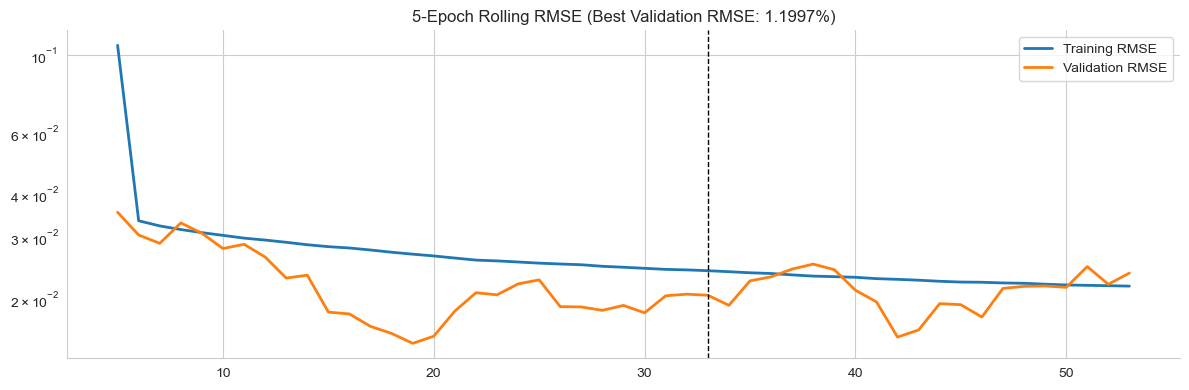

In [18]:
#===============================================================================================================================
# RESULTS - PERFORMANCE vs EPOCHS - TRAIN, VALIDATION
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_error', dpi=300);

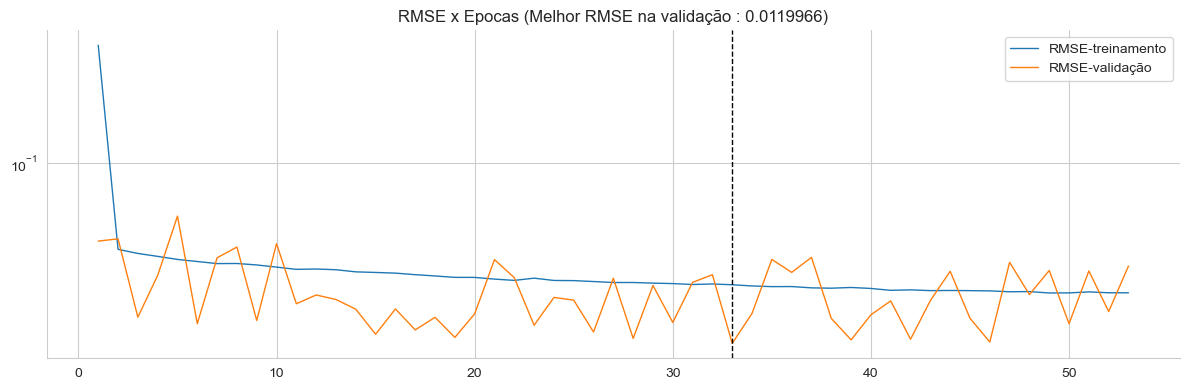

In [19]:
#===============================================================================================================================
# RESULTS - PERFORMANCE vs EPOCHS - TRAIN, VALIDATION
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'RMSE x Epocas (Melhor RMSE na validação : {best_rmse:.6})'
loss_history.columns=['RMSE-treinamento', 'RMSE-validação']
loss_history.rolling(1).mean().plot(logy=True, lw=1, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_error', dpi=300);

In [20]:
#===============================================================================================================================
# RESULTS - PERFORMANCE - TRAIN, TEST
#===============================================================================================================================
train_rmse_scaled = np.sqrt(rnn.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(rnn.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')
#-------------------------------------------------------------------------------------------------------------------------------
# Train RMSE: 0.0176 | Test RMSE: 0.0108
#-------------------------------------------------------------------------------------------------------------------------------

Train RMSE: 0.0199 | Test RMSE: 0.0120


In [21]:
#===============================================================================================================================
# RESULTS - FORECAST - TRAIN, TEST
#===============================================================================================================================
train_predict_scaled = rnn.predict(X_train)
test_predict_scaled = rnn.predict(X_test)

8/8 [==============================] - 0s 5ms/step


In [22]:
#===============================================================================================================================
# RESULTS - SPEARMAN IC - TRAIN, TEST
#===============================================================================================================================
train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f'Train IC: {train_ic:.6f} | Test IC: {test_ic:.4f}')
#-------------------------------------------------------------------------------------------------------------------------------
# Train IC: 0.983348 | Test IC: 0.9191
#-------------------------------------------------------------------------------------------------------------------------------

Train IC: 0.980948 | Test IC: 0.9005


In [23]:
#===============================================================================================================================
# RESULTS - FORECAST - RESULTS - TEST
#===============================================================================================================================
np.savetxt('Data/Output/LSTM-Jansen-FracDiff-Ln-Daily-Scaled-Test.txt', test_predict_scaled, delimiter=';')
test_predict_scaled[:,0]

array([1.8805572, 1.869618 , 1.8594303, 1.8608035, 1.868884 , 1.8754408,
       1.8778647, 1.8840477, 1.8910413, 1.8907571, 1.8877114, 1.8813527,
       1.8867097, 1.8903514, 1.8933494, 1.8912178, 1.8895674, 1.8929708,
       1.8974646, 1.8981441, 1.8923556, 1.8905452, 1.8934431, 1.8897386,
       1.8825103, 1.8752487, 1.8738734, 1.8704925, 1.8765224, 1.8717419,
       1.8708951, 1.8731983, 1.8706582, 1.8758478, 1.8783479, 1.8766714,
       1.8697371, 1.8695183, 1.8635447, 1.8618915, 1.8589802, 1.8566065,
       1.8526094, 1.8537283, 1.8571606, 1.8567882, 1.8648702, 1.8622961,
       1.8570545, 1.8542473, 1.8531225, 1.8522257, 1.8549287, 1.8508897,
       1.8464818, 1.8459253, 1.8433518, 1.8348024, 1.8363109, 1.8401158,
       1.8469739, 1.8513579, 1.8596159, 1.8557703, 1.8538454, 1.8548462,
       1.8522022, 1.8512278, 1.8548127, 1.8708708, 1.8774173, 1.8779051,
       1.8775069, 1.8764837, 1.8766474, 1.8690102, 1.8685435, 1.8668607,
       1.8639112, 1.8599797, 1.8610687, 1.8664932, 

In [24]:
#===============================================================================================================================
# FRACDIFF: RECOVER - PRICES - d, THRESHOLD
#===============================================================================================================================
d=0.2645
THRESHOLD=1e-4

In [25]:
#===============================================================================================================================
# FRACDIFF: RECOVER - FUNCTION WEIGHTS
#===============================================================================================================================
def getWeights_FFD(d, thres=THRESHOLD, lim=10000):
    w, k = [1.], 1                          # Set w as a list and k as one
    ctr = 0                                 # Set ctr
    while True:                             # Loop While
        w_ = -w[-1] / k * (d - k + 1)          # Create the new weight value
        if abs(w_) < thres:break               # End the loop in case the threshold is breached
        w.append(w_)                           # Append the new value of w
        k += 1                                 # Increment k
        ctr += 1                               # Increment ctr
        if ctr == lim - 1:break                # End the loop in case it breaches the limit
    return np.array(w[::-1]).reshape(-1, 1) # Convert the w from list to a numpy array

In [26]:
#===============================================================================================================================
# FRACDIFF: RECOVER - WEIGHTS
#===============================================================================================================================
#w_FFD = getWeights_FFD(d, thres=1e-6, lim=5942-428+2)
w_FFD = getWeights_FFD(d, thres=1e-6, lim=248)
print(len(w_FFD[:-1]))
w_FFD[:]

247


array([[-2.00408311e-04],
       [-2.01439568e-04],
       [-2.02480366e-04],
       [-2.03530835e-04],
       [-2.04591103e-04],
       [-2.05661303e-04],
       [-2.06741571e-04],
       [-2.07832042e-04],
       [-2.08932857e-04],
       [-2.10044158e-04],
       [-2.11166088e-04],
       [-2.12298797e-04],
       [-2.13442432e-04],
       [-2.14597147e-04],
       [-2.15763098e-04],
       [-2.16940442e-04],
       [-2.18129341e-04],
       [-2.19329959e-04],
       [-2.20542463e-04],
       [-2.21767024e-04],
       [-2.23003815e-04],
       [-2.24253013e-04],
       [-2.25514798e-04],
       [-2.26789354e-04],
       [-2.28076868e-04],
       [-2.29377531e-04],
       [-2.30691538e-04],
       [-2.32019086e-04],
       [-2.33360378e-04],
       [-2.34715619e-04],
       [-2.36085021e-04],
       [-2.37468796e-04],
       [-2.38867165e-04],
       [-2.40280348e-04],
       [-2.41708575e-04],
       [-2.43152076e-04],
       [-2.44611089e-04],
       [-2.46085855e-04],
       [-2.4

In [27]:
#===============================================================================================================================
# PREDICTION FFD: y_pred_fracdiff
#===============================================================================================================================
#y_pred_fracdiff=df.loc['2023-01-31':,'predictions'].to_frame()
#y_pred_fracdiff.rename(columns={'predictions':'Residuals'}, inplace=True)
y_pred_fracdiff=pd.DataFrame(test_predict_scaled, columns=['Residuals'])
y_pred_fracdiff[-248:]


,Residuals
0,1.880557
1,1.869618
2,1.859430
3,1.860803
4,1.868884
...,...
243,1.935735
244,1.938269
245,1.939916
246,1.941932


In [28]:
#===============================================================================================================================
# DATA: READ - PRICES - ORI
#===============================================================================================================================
seriesId = 'IBOV'
df_temp = pd.read_csv(seriesId+'.csv')

df_test_ori = df_temp.copy()
df_test_ori['Date'] = pd.to_datetime(df_test_ori['Date'], dayfirst=True)
df_test_ori = df_test_ori.loc[:, ['Date', 'Close']]
df_test_ori = df_test_ori.set_index('Date')
df_test_ori = df_test_ori['2022-01-06':]
#df_test_ori = df_test_ori['2022-01-07':]
df_test_ori['Close'] = np.log(df_test_ori['Close'])
df_test_ori[-248:]

,Close
Date,
2023-01-02,11.574735
2023-01-03,11.553739
2023-01-04,11.564896
2023-01-05,11.586560
2023-01-06,11.598770
...,...
2023-12-21,11.791935
2023-12-22,11.796245
2023-12-26,11.802103


In [29]:
#===============================================================================================================================
# RESULTS: RECOVER - FRACDIFF - FUNCTION
#===============================================================================================================================
def fracDiff_FFD_recover(series_ffd,d,thres=THRESHOLD, w=None,series_ori=None):

    width=len(w)
    
    df= {}
    prices_ori,df_=series_ori, pd.Series() 
    
    print('width = ',width)
    print('')
    #---------------------------------------------------------------------------------------------------------------------------
    # Loop W
    #---------------------------------------------------------------------------------------------------------------------------
    for iloc1 in range(0,width):
        print('-------------------------------------------------')
        #-----------------------------------------------------------------------------------------------------------------------
        # loc0, loc1
        #-----------------------------------------------------------------------------------------------------------------------
        loc0=prices_ori.index[iloc1]
        loc1=prices_ori.index[iloc1-width-1]
        locffd0=series_ffd.index[iloc1]

        print('')
        print('Loop: iloc1=', iloc1, ' | loc0=', loc0, ' | loc1=', loc1, ' | locffd0=', locffd0)

        if not (np.isfinite(series_ori.loc[loc1])).any():continue

        print('')
        print('w[iloc1]           = ', np.round(w[iloc1],8))
        print('series_ori[loc0]   = ', series_ori.loc[loc0,'Close'])
        print('series_ori[loc1]   = ', series_ori.loc[loc1,'Close'])
        print('series_ffd[locffd0]= ', series_ffd.loc[locffd0,'Residuals'])
            
        #-----------------------------------------------------------------------------------------------------------------------
        # Dot Product w x series_ori[loc0:loc1]
        #-----------------------------------------------------------------------------------------------------------------------
        
        loc2=prices_ori.index[iloc1-width]
        df_[loc2]=np.dot(w[:-1].T,series_ori.loc[loc0:loc1])[0]
        print('dot(w, series_ori  = ', df_[loc2])
        print('ffd[Residuals]     = ', series_ffd.loc[locffd0,'Residuals'])

        df_[loc2]=np.round(series_ffd.loc[locffd0,'Residuals'] - df_[loc2],8)
        print('Pred               = ', np.round(df_[loc2],6))

    df['Close']=df_.copy(deep=True)
    df=pd.concat(df,axis=1)

    return df

In [30]:
#===============================================================================================================================
# RESULTS: FRACDIFF - RECOVER - LN
#===============================================================================================================================
test_predict_recover_ffd = fracDiff_FFD_recover(y_pred_fracdiff[-248:], d, THRESHOLD, w_FFD[:], df_test_ori)

width =  248

-------------------------------------------------

Loop: iloc1= 0  | loc0= 2022-01-06 00:00:00  | loc1= 2022-12-29 00:00:00  | locffd0= 0

w[iloc1]           =  [-0.00020041]
series_ori[loc0]   =  11.5284153744812
series_ori[loc1]   =  11.605820002185194
series_ffd[locffd0]=  1.8805572
dot(w, series_ori  =  [-9.43240948]
ffd[Residuals]     =  1.8805572
Pred               =  11.312967
-------------------------------------------------

Loop: iloc1= 1  | loc0= 2022-01-07 00:00:00  | loc1= 2023-01-02 00:00:00  | locffd0= 1

w[iloc1]           =  [-0.00020144]
series_ori[loc0]   =  11.539756959253156
series_ori[loc1]   =  11.574735454548858
series_ffd[locffd0]=  1.869618
dot(w, series_ori  =  [-9.42480228]
ffd[Residuals]     =  1.869618
Pred               =  11.29442
-------------------------------------------------

Loop: iloc1= 2  | loc0= 2022-01-10 00:00:00  | loc1= 2023-01-03 00:00:00  | locffd0= 2

w[iloc1]           =  [-0.00020248]
series_ori[loc0]   =  11.5321906929913

Loop: iloc1= 50  | loc0= 2022-03-21 00:00:00  | loc1= 2023-03-14 00:00:00  | locffd0= 50

w[iloc1]           =  [-0.00026681]
series_ori[loc0]   =  11.662676738729457
series_ori[loc1]   =  11.541827546763727
series_ffd[locffd0]=  1.8531225
dot(w, series_ori  =  [-9.40168921]
ffd[Residuals]     =  1.8531225
Pred               =  11.254812
-------------------------------------------------

Loop: iloc1= 51  | loc0= 2022-03-22 00:00:00  | loc1= 2023-03-15 00:00:00  | locffd0= 51

w[iloc1]           =  [-0.00026853]
series_ori[loc0]   =  11.672255053924081
series_ori[loc1]   =  11.539328321576294
series_ffd[locffd0]=  1.8522257
dot(w, series_ori  =  [-9.39973826]
ffd[Residuals]     =  1.8522257
Pred               =  11.251964
-------------------------------------------------

Loop: iloc1= 52  | loc0= 2022-03-23 00:00:00  | loc1= 2023-03-16 00:00:00  | locffd0= 52

w[iloc1]           =  [-0.00027028]
series_ori[loc0]   =  11.673830482812935
series_ori[loc1]   =  11.546695387983238
series_ffd

dot(w, series_ori  =  [-9.43898337]
ffd[Residuals]     =  1.8990425
Pred               =  11.338026
-------------------------------------------------

Loop: iloc1= 107  | loc0= 2022-06-10 00:00:00  | loc1= 2023-06-06 00:00:00  | locffd0= 107

w[iloc1]           =  [-0.00041108]
series_ori[loc0]   =  11.566288301377618
series_ori[loc1]   =  11.649291212014576
series_ffd[locffd0]=  1.9052843
dot(w, series_ori  =  [-9.4452071]
ffd[Residuals]     =  1.9052843
Pred               =  11.350491
-------------------------------------------------

Loop: iloc1= 108  | loc0= 2022-06-13 00:00:00  | loc1= 2023-06-07 00:00:00  | locffd0= 108

w[iloc1]           =  [-0.00041483]
series_ori[loc0]   =  11.538575472770049
series_ori[loc1]   =  11.656923292866882
series_ffd[locffd0]=  1.9092258
dot(w, series_ori  =  [-9.45013146]
ffd[Residuals]     =  1.9092258
Pred               =  11.359357
-------------------------------------------------

Loop: iloc1= 109  | loc0= 2022-06-14 00:00:00  | loc1= 2023-06-0


w[iloc1]           =  [-0.00067162]
series_ori[loc0]   =  11.635426066504586
series_ori[loc1]   =  11.68189806963487
series_ffd[locffd0]=  1.9027184
dot(w, series_ori  =  [-9.49263543]
ffd[Residuals]     =  1.9027184
Pred               =  11.395354
-------------------------------------------------

Loop: iloc1= 153  | loc0= 2022-08-16 00:00:00  | loc1= 2023-08-10 00:00:00  | locffd0= 153

w[iloc1]           =  [-0.00068068]
series_ori[loc0]   =  11.639667184845228
series_ori[loc1]   =  11.681398235130757
series_ffd[locffd0]=  1.9017187
dot(w, series_ori  =  [-9.49172634]
ffd[Residuals]     =  1.9017187
Pred               =  11.393445
-------------------------------------------------

Loop: iloc1= 154  | loc0= 2022-08-17 00:00:00  | loc1= 2023-08-11 00:00:00  | locffd0= 154

w[iloc1]           =  [-0.00068996]
series_ori[loc0]   =  11.64138692718984
series_ori[loc1]   =  11.678991785031448
series_ffd[locffd0]=  1.9004601
dot(w, series_ori  =  [-9.49060655]
ffd[Residuals]     =  1.90046

dot(w, series_ori  =  [-9.49436136]
ffd[Residuals]     =  1.9105983
Pred               =  11.40496
-------------------------------------------------

Loop: iloc1= 218  | loc0= 2022-11-21 00:00:00  | loc1= 2023-11-14 00:00:00  | locffd0= 218

w[iloc1]           =  [-0.00302351]
series_ori[loc0]   =  11.605943747656408
series_ori[loc1]   =  11.721286369376136
series_ffd[locffd0]=  1.9184092
dot(w, series_ori  =  [-9.50160134]
ffd[Residuals]     =  1.9184092
Pred               =  11.420011
-------------------------------------------------

Loop: iloc1= 219  | loc0= 2022-11-22 00:00:00  | loc1= 2023-11-16 00:00:00  | locffd0= 219

w[iloc1]           =  [-0.00316135]
series_ori[loc0]   =  11.599438334392271
series_ori[loc1]   =  11.733178763525009
series_ffd[locffd0]=  1.9242375
dot(w, series_ori  =  [-9.50793031]
ffd[Residuals]     =  1.9242375
Pred               =  11.432168
-------------------------------------------------

Loop: iloc1= 220  | loc0= 2022-11-23 00:00:00  | loc1= 2023-11-1

In [31]:
#===============================================================================================================================
# RESULTS: RECOVER - LN - TEST - test_predict_scaled_recover 
#===============================================================================================================================
test_predict_recover_ffd

,Close
2023-01-02,11.31296666
2023-01-03,11.29442034
2023-01-04,11.27614114
2023-01-05,11.27706038
2023-01-06,11.28988724
...,...
2023-12-21,11.4899194
2023-12-22,11.49587042
2023-12-26,11.50038684
2023-12-27,11.50563964


In [32]:
#===============================================================================================================================
# RESULTS: - OUTPUT - LN - TEST
#===============================================================================================================================
np.savetxt('Data/Output/LSTM-Jansen-FracDiff-Ln-Daily-Test.txt' , test_predict_recover_ffd , delimiter=';')


In [33]:
#===============================================================================================================================
# RESULTS - TARGET - LN - TEST
#===============================================================================================================================
y_test_rescaled=df_test_ori[-248:]
y_test_rescaled

,Close
Date,
2023-01-02,11.574735
2023-01-03,11.553739
2023-01-04,11.564896
2023-01-05,11.586560
2023-01-06,11.598770
...,...
2023-12-21,11.791935
2023-12-22,11.796245
2023-12-26,11.802103


In [34]:
#===============================================================================================================================
# RESULTS - LN - PERFORMANCE - TRAIN, TEST
#===============================================================================================================================
#train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(test_predict_recover_ffd, y_test_rescaled))
print(f'Test RMSE: {test_rmse:.2f}')
#-------------------------------------------------------------------------------------------------------------------------------
# Test RMSE: 0.29
#-------------------------------------------------------------------------------------------------------------------------------

Test RMSE: 0.29


In [35]:
#===============================================================================================================================
# RESULTS - PRICE - STORE - TRAIN, TEST
#===============================================================================================================================
#df['Train Predictions'] = train_predict
#df.loc['2023-01-02':,'Test Predictions'] = test_predict_recover_ffd
df['Test Predictions'] = test_predict_recover_ffd
df['predictions'] = test_predict_recover_ffd

#temp = pd.concat([train_predict.to_frame('predictions').assign(data='Train'), test_predict.to_frame('predictions').assign(data='Test')])

#df['predictions'] = temp['predictions']
#df['data']        = temp[ 'data']

df['2022-12-25':]

,Close,Test Predictions,predictions
Date,,,
2022-12-26,1.875974,NaN,NaN
2022-12-27,1.874472,NaN,NaN
2022-12-28,1.889505,NaN,NaN
2022-12-29,1.880656,NaN,NaN
2023-01-02,1.849074,11.31296666,11.31296666
...,...,...,...
2023-12-21,1.945807,11.4899194,11.4899194
2023-12-22,1.946708,11.49587042,11.49587042
2023-12-26,1.949707,11.50038684,11.50038684


In [36]:
#===============================================================================================================================
# RESULTS - PRICE - EXPORT
#===============================================================================================================================
df.to_excel('Data/Output/LSTM-Jansen-FracDiff-Ln-Daily.xlsx')

TypeError: no numeric data to plot

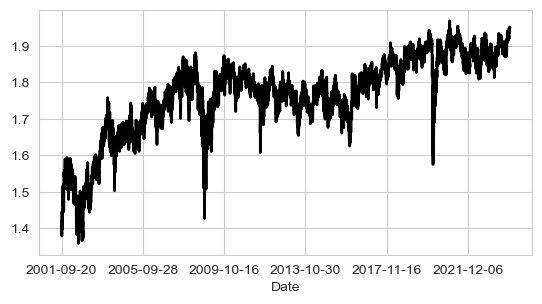

In [37]:
#===============================================================================================================================
# RESULTS - PRICE - PLOT
#===============================================================================================================================
fig=plt.figure(figsize=(14,7))

ax1 = plt.subplot(221)
df.loc['2000':, 'Close'].plot(lw=2, ax=ax1, c='k')
df.loc['2000':, 'predictions'].plot(lw=1.5, ax=ax1, c='k')
df.loc['2000':, ['Test Predictions', 'Train Predictions']].plot(lw=1, ax=ax1, ls='--')
ax1.set_title('In- and Out-of-sample Predictions')

with sns.axes_style("white"):
    ax3 = plt.subplot(223)
    sns.scatterplot(x='Close', y='predictions', data=df, hue='data', ax=ax3)
    ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic:.2%}', transform=ax3.transAxes)
    ax3.text(x=.02, y=.87, s=f'Train IC={train_ic:.2%}', transform=ax3.transAxes)
    ax3.set_title('Correlation')
    ax3.legend(loc='lower right')
    
    ax2 = plt.subplot(222)
    ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)
    sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
    ax2.set_title('Train Error')
    ax2.text(x=.03, y=.92, s=f'Train RMSE ={train_rmse:.4f}', transform=ax2.transAxes)
    sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)
    ax4.set_title('Test Error')
    ax4.text(x=.03, y=.92, s=f'Test RMSE ={test_rmse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_regression', dpi=300);


In [ ]:
#===============================================================================================================================
# RESULTS - FRACDIFF - RECOVER - PRED - TRAIN, TEST
#===============================================================================================================================
test_predict  = np.exp(test_predict_scaled)

test_predict